# Face Recognition Demo

In [5]:
%reload_ext autoreload
%autoreload 2

import os
from os.path import join
from glob import glob
from random import randint
from pathlib import Path

import numpy as np
import pandas as pd
import cv2 as cv
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.utils import im_utils, file_utils
from app.models.bbox import BBox

In [6]:
DATA_STORE = '/data_store/'
dir_datasets = join(DATA_STORE, 'datasets/people')
dir_lfw = join(dir_datasets, 'lfw')
dir_lfw_metadata = join(dir_lfw, 'metadata')
dir_lfw_images = join(dir_lfw, 'images')

## Files

In [7]:
# set fp_
fp_identities = join(dir_lfw_metadata, 'identities.csv')
fp_files = join(dir_lfw_metadata, 'files.csv')
fp_index = join(dir_lfw_metadata, 'shas.csv')
fp_rois = join(dir_lfw_metadata, 'rois.csv')
fp_uuids = join(dir_lfw_metadata, 'uuids.csv')
fp_pose = join(dir_lfw_metadata, 'pose.csv')
fp_vecs = join(dir_lfw_metadata, 'vecs.csv')

In [8]:
# load csvs into dataframes
df_identities = pd.read_csv(fp_identities).set_index('index')
df_files = pd.read_csv(fp_files).set_index('index')
df_index = pd.read_csv(fp_index).set_index('index')
df_rois = pd.read_csv(fp_rois).set_index('index')
df_uuids = pd.read_csv(fp_uuids).set_index('index')
df_pose = pd.read_csv(fp_pose).set_index('index')
df_vecs = pd.read_csv(fp_vecs).set_index('index')

### Load Image

In [131]:
rn = randint(0,len(df_files))
ds_file = df_files.iloc[rn]
fp_im = join(dir_lfw_images, str(ds_file.subdir), f'{ds_file.fn}.{ds_file.ext}')
print(fp_im)

/data_store/datasets/people/lfw/images/Daisy_Fuentes/Daisy_Fuentes_0004.jpg


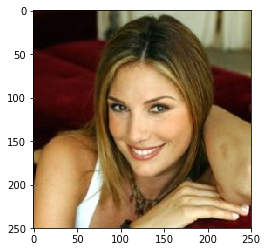

In [132]:
im = cv.imread(fp_im)
im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
plt.imshow(im_rgb)

### Detect Face

- use dlib HoG detector

In [133]:
from app.processors import face_detector
detector = face_detector.DetectorDLIBHOG()

In [134]:
# get detection as BBox object
bboxes = detector.detect(im, largest=True)
bbox = bboxes[0]
dim = im.shape[:2][::-1]
bbox = bbox.to_dim(dim)  # convert back to real dimensions

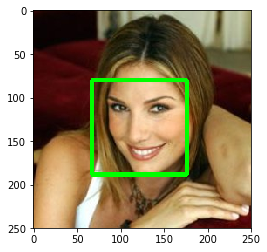

In [135]:
# draw detection
dst_rgb = im_rgb.copy()
cv.rectangle(dst_rgb, bbox.pt_tl, bbox.pt_br, (0,255,0), 4)
plt.imshow(dst_rgb)

### Face vectors

- extract 128 vectors using dlib face recognition model

In [136]:
import dlib
from app.processors import face_recognition
recognition = face_recognition.RecognitionDLIB(gpu=-1)

In [137]:
# extract the face vectors
vec = recognition.vec(im, bbox)
print(len(vec), vec[0])

128 -0.13902714848518372


### Face match

- find most similar match in the df_vecs

In [138]:
# convert the CSV to float list of vecs
vecs = [list(map(float,x.vec.split(','))) for x in df_vecs.itertuples()]
# find similarities using linalg
vecs_sim = np.linalg.norm(np.array([vec]) - np.array(vecs), axis=1)
# find the best match idx
vec_most_sim = np.argmin(vecs_sim)
print(f'best match roi index is {vec_most_sim} with distance: {vecs_sim[vec_most_sim]}')

best match roi index is 2522 with distance: 0.08698654273556798


In [139]:
# partition the array to get the top 5 roi indices of top 5 matches
nmatches = 5
top_idxs = np.argpartition(vecs_sim, nmatches)[:nmatches]
print(top_idxs)

[2522 6120 2520 2519 2521]


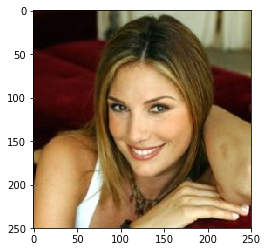

In [143]:
# use the most sim vec to get the file
ds_roi = df_rois.iloc[top_idxs[0]]
image_idx = int(ds_roi.image_index)
# use the image idx to get the file meta
ds_file = df_files.iloc[image_idx]
# construct filepath
fp_match = join(dir_lfw_images, str(ds_file.subdir), f'{ds_file.fn}.{ds_file.ext}')
im_match = cv.imread(fp_match)
im_match_rgb = cv.cvtColor(im_match, cv.COLOR_BGR2RGB)
plt.imshow(im_match_rgb)

In [144]:
# convert above to function
def roi_idx_to_image(roi_idx):
  ds_roi = df_rois.iloc[roi_idx]
  image_idx = int(ds_roi.image_index)
  # use the image idx to get the file meta
  ds_file = df_files.iloc[image_idx]
  # construct filepath
  fp_match = join(dir_lfw_images, str(ds_file.subdir), f'{ds_file.fn}.{ds_file.ext}')
  im_match = cv.imread(fp_match)
  return im_match  

### Plot match results

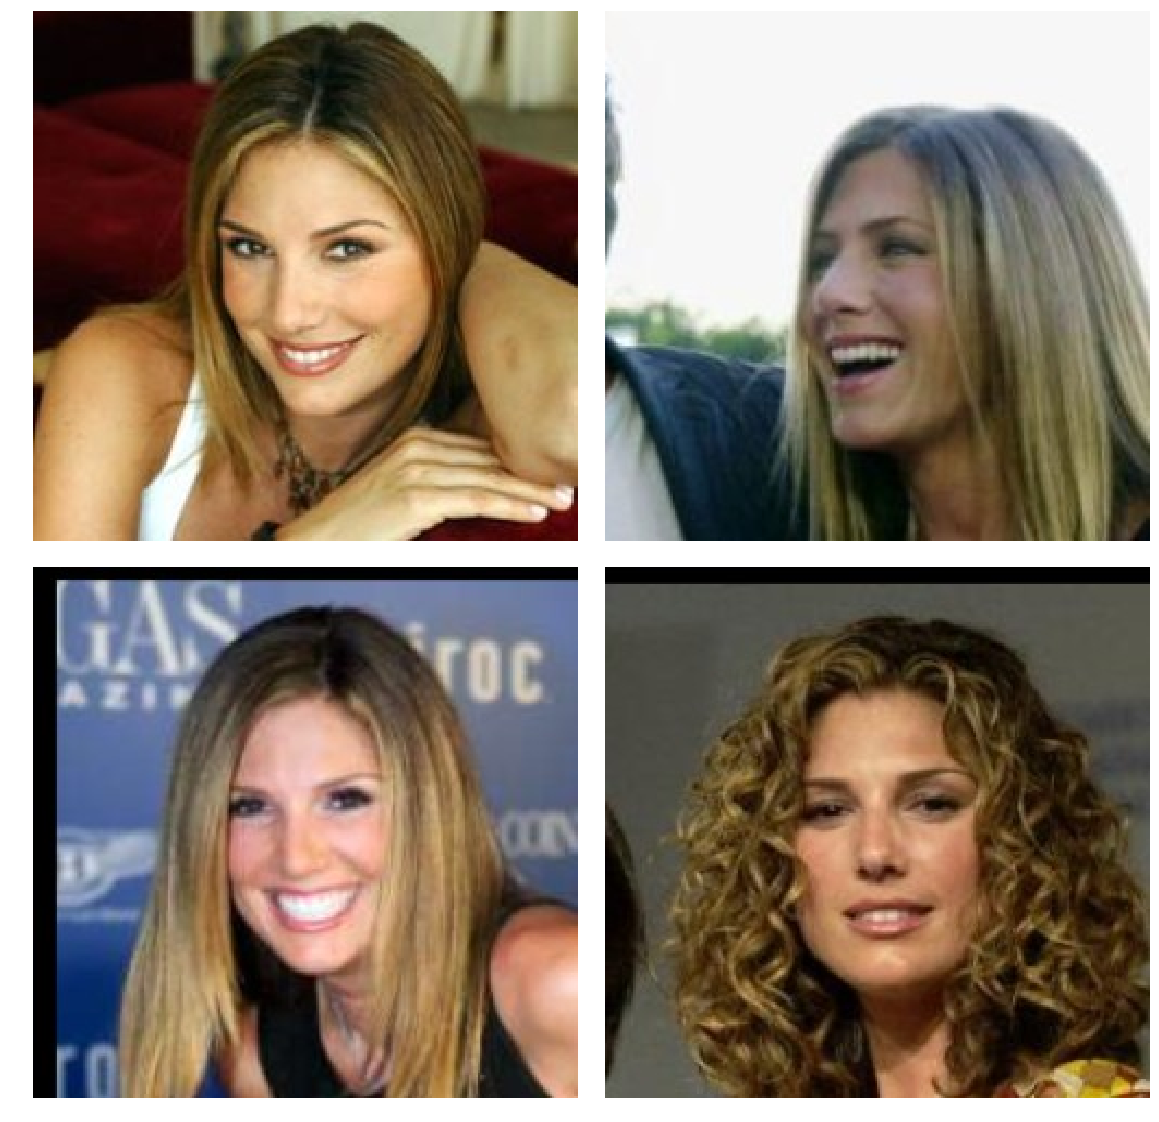

In [145]:
ims = [roi_idx_to_image(x) for x in top_idxs]
max_cols = 2
max_rows = 2
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,20))
for idx, im in enumerate(ims[:max_rows*max_cols]):
  row = idx // max_cols
  col = idx % max_cols
  axes[row, col].axis("off")
  im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
  axes[row, col].imshow(im_rgb, aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

In [ ]:
import imutils